In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghost5612","key":"dff609f69209249df7df094cbb770ca9"}'}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [ ]:
!unzip -q skin-cancer-mnist-ham10000.zip -d skin_cancer_data

In [ ]:
import os

# Show first 10 files in the dataset
for root, dirs, files in os.walk("skin_cancer_data"):
    for name in files[:10]:
        print(os.path.join(root, name))

skin_cancer_data/hmnist_28_28_L.csv
skin_cancer_data/hmnist_8_8_RGB.csv
skin_cancer_data/hmnist_8_8_L.csv
skin_cancer_data/hmnist_28_28_RGB.csv
skin_cancer_data/HAM10000_metadata.csv
skin_cancer_data/HAM10000_images_part_1/ISIC_0026280.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0027411.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0026401.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0026624.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0028897.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0026046.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0027541.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0027110.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0029212.jpg
skin_cancer_data/HAM10000_images_part_1/ISIC_0026664.jpg
skin_cancer_data/ham10000_images_part_2/ISIC_0032875.jpg
skin_cancer_data/ham10000_images_part_2/ISIC_0034213.jpg
skin_cancer_data/ham10000_images_part_2/ISIC_0033680.jpg
skin_cancer_data/ham10000_images_part_2/ISIC_0029819.jpg
skin_cancer_data/ha

In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:
# Load metadata
df = pd.read_csv('skin_cancer_data/HAM10000_metadata.csv')

# Resolve paths (images are in two subfolders)
def resolve_path(image_id):
    p1 = f'skin_cancer_data/HAM10000_images_part_1/{image_id}.jpg'
    p2 = f'skin_cancer_data/HAM10000_images_part_2/{image_id}.jpg'
    return p1 if os.path.exists(p1) else p2

df['image_path'] = df['image_id'].apply(resolve_path)

# Encode diagnosis labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

# Split into train and validation
train_df, val_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)

train_df[:5],val_df[:5]

(        lesion_id      image_id     dx    dx_type   age     sex  \
 8050  HAM_0005972  ISIC_0033319     nv      histo  35.0  female   
 4898  HAM_0004902  ISIC_0030823     nv  follow_up  40.0    male   
 9695  HAM_0005282  ISIC_0028730  akiec      histo  65.0    male   
 4090  HAM_0000475  ISIC_0027299     nv  follow_up  40.0    male   
 8625  HAM_0000949  ISIC_0032444     nv      histo  65.0    male   
 
          localization                                         image_path  \
 8050  lower extremity  skin_cancer_data/HAM10000_images_part_2/ISIC_0...   
 4898            trunk  skin_cancer_data/HAM10000_images_part_2/ISIC_0...   
 9695  lower extremity  skin_cancer_data/HAM10000_images_part_1/ISIC_0...   
 4090  lower extremity  skin_cancer_data/HAM10000_images_part_1/ISIC_0...   
 8625             back  skin_cancer_data/HAM10000_images_part_2/ISIC_0...   
 
       label  
 8050      5  
 4898      5  
 9695      0  
 4090      5  
 8625      5  ,
         lesion_id      image_id   

In [ ]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Image size for most pretrained models (ResNet, EfficientNet, etc.)
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [ ]:
BATCH_SIZE = 32

train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader
val_loader

In [ ]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels[:10]}")

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([5, 5, 5, 1, 4, 0, 5, 5, 4, 5])


In [ ]:
# Label to class mapping
idx_to_class = {i: c for i, c in enumerate(label_encoder.classes_)}
print(idx_to_class)


{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the classifier head (HAM10000 has 7 classes)
num_classes = df['label'].nunique()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training
        model.train()
        train_loss, train_correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        # Logging
        train_acc = 100 * train_correct / len(train_loader.dataset)
        val_acc = 100 * val_correct / len(val_loader.dataset)
        print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step()


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
------------------------------
Train Loss: 0.7229, Accuracy: 74.49%
Val Loss: 0.5159, Accuracy: 80.93%

Epoch 2/10
------------------------------
Train Loss: 0.4537, Accuracy: 83.56%
Val Loss: 0.4613, Accuracy: 83.33%

Epoch 3/10
------------------------------
Train Loss: 0.3664, Accuracy: 86.32%
Val Loss: 0.4313, Accuracy: 84.62%

Epoch 4/10
------------------------------
Train Loss: 0.2986, Accuracy: 88.93%
Val Loss: 0.4098, Accuracy: 85.22%

Epoch 5/10
------------------------------
Train Loss: 0.2499, Accuracy: 90.76%
Val Loss: 0.4312, Accuracy: 85.37%

Epoch 6/10
------------------------------
Train Loss: 0.1603, Accuracy: 94.70%
Val Loss: 0.3411, Accuracy: 87.62%

Epoch 7/10
------------------------------
Train Loss: 0.1247, Accuracy: 96.02%
Val Loss: 0.3391, Accuracy: 88.17%

Epoch 8/10
------------------------------
Train Loss: 0.1051, Accuracy: 96.80%
Val Loss: 0.3373, Accuracy: 88.07%

Epoch 9/10
------------------------------
Train Loss: 0.0964, Accuracy: 96.95%


In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt

# Same transform as validation
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_image(model, image_path, idx_to_class):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = predict_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][pred_class].item()

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {idx_to_class[pred_class]} ({confidence:.2f})")
    plt.show()


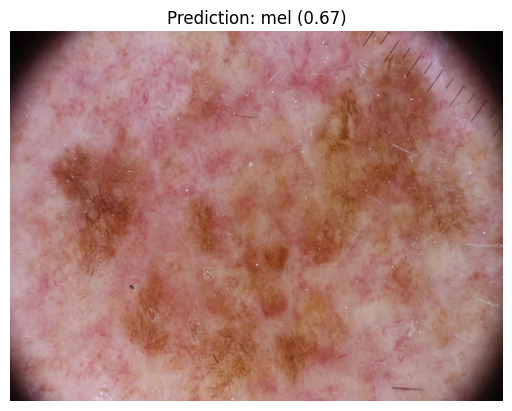

In [ ]:
predict_image(model, val_df.iloc[2]['image_path'], idx_to_class)

In [ ]:
!pip install -U grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s e

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Target layer for ResNet18
target_layers = [model.layer4[-1]]

def visualize_gradcam(image_path, model, class_idx):
    image = Image.open(image_path).convert('RGB')
    rgb_img = image.resize((224, 224))
    input_tensor = predict_transform(rgb_img).unsqueeze(0).to(device)

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Convert image to numpy for overlay
    rgb_np = transforms.ToTensor()(rgb_img).permute(1, 2, 0).numpy()
    rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min())

    cam_image = show_cam_on_image(rgb_np, grayscale_cam, use_rgb=True)

    plt.imshow(cam_image)
    plt.axis('off')
    plt.title(f"Grad-CAM for class: {idx_to_class[class_idx]}")
    plt.show()


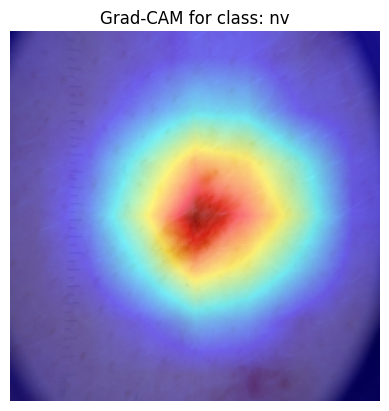

In [ ]:
visualize_gradcam(val_df.iloc[0]['image_path'], model, class_idx=val_df.iloc[0]['label'])

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            correct_train += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = 100 * correct_train / len(train_loader.dataset)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * images.size(0)
                correct_val += (outputs.argmax(1) == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = 100 * correct_val / len(val_loader.dataset)

        # Append to history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Print progress
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step()

    # Return model and metrics
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



Epoch 1/10
------------------------------
Train Loss: 0.0785, Accuracy: 97.83%
Val Loss: 0.3419, Accuracy: 89.12%

Epoch 2/10
------------------------------
Train Loss: 0.0763, Accuracy: 97.77%
Val Loss: 0.3522, Accuracy: 88.87%

Epoch 3/10
------------------------------
Train Loss: 0.0746, Accuracy: 97.89%
Val Loss: 0.3421, Accuracy: 88.87%

Epoch 4/10
------------------------------
Train Loss: 0.0741, Accuracy: 97.88%
Val Loss: 0.3414, Accuracy: 88.37%

Epoch 5/10
------------------------------
Train Loss: 0.0764, Accuracy: 97.84%
Val Loss: 0.3409, Accuracy: 89.17%

Epoch 6/10
------------------------------
Train Loss: 0.0681, Accuracy: 98.17%
Val Loss: 0.3400, Accuracy: 88.67%

Epoch 7/10
------------------------------
Train Loss: 0.0706, Accuracy: 98.12%
Val Loss: 0.3489, Accuracy: 88.62%

Epoch 8/10
------------------------------
Train Loss: 0.0691, Accuracy: 98.22%
Val Loss: 0.3517, Accuracy: 88.37%

Epoch 9/10
------------------------------
Train Loss: 0.0706, Accuracy: 98.15%


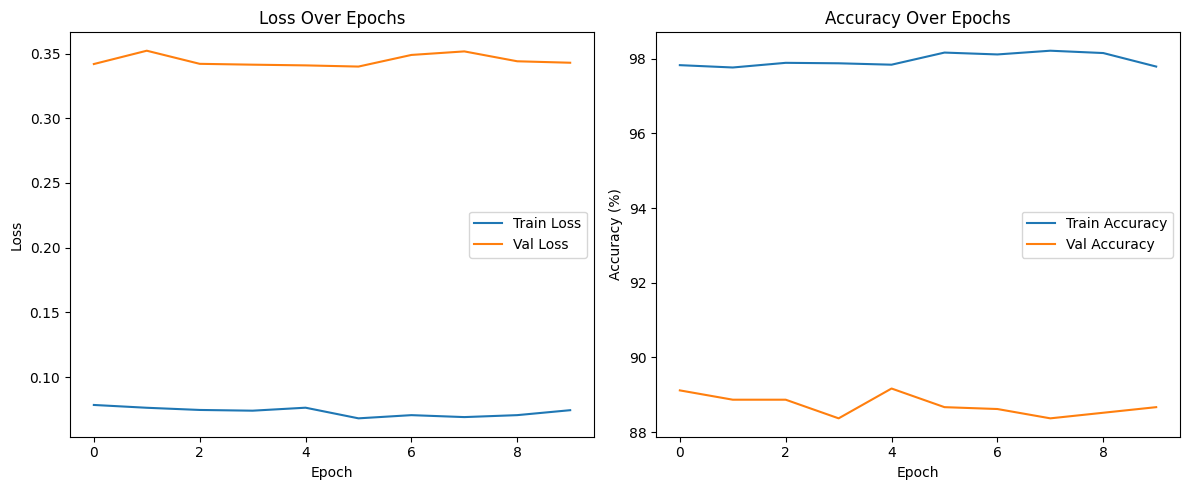

In [ ]:
# Train and get the history
model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10
)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/resnet18_skin_cancer.pth")

In [ ]:
torch.save(model, "/content/resnet18_skin_cancer.keras")